# Logistic Regression from Scratch

**Welcome back, St. Mark!** Building on linear regression, we now tackle classification. Think of this as upgrading from measuring disease severity (regression) to diagnosing disease presence (classification).

We'll explore:

1. **Binary Logistic Regression** - Sigmoid activation and log-loss
2. **Gradient Descent Training** - Adapting our optimization techniques
3. **Multiclass Extension** - Softmax for multiple disease categories
4. **Decision Boundaries** - Visualizing classification regions

By the end, you'll understand how neural networks classify data.

## The Big Picture

Logistic regression is classification through regression:
- **Features (X)**: Input measurements (clinical symptoms)
- **Sigmoid Function**: Converts linear outputs to probabilities (0-1)
- **Decision Boundary**: Threshold for classification (usually 0.5)
- **Log Loss**: Measures classification error instead of squared error

**Key Question:** How do we predict disease categories instead of continuous measurements?

## Data Preparation: Binary Classification Setup

We'll use scikit-learn's `make_classification` to create synthetic data mimicking disease diagnosis scenarios.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create synthetic binary classification data
# n_classes=2 for disease present/absent
# n_clusters_per_class=1 for clear separation
X, y = make_classification(n_samples=1000,
                          n_features=4,
                          n_classes=2,
                          n_informative=3,
                          n_redundant=1,
                          n_clusters_per_class=1,
                          random_state=42)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add intercept term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Reshape targets for matrix operations
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Training set: X={X_train_b.shape}, y={y_train.shape}")
print(f"Test set: X={X_test_b.shape}, y={y_test.shape}")
print(f"Class distribution: {np.bincount(y_train.flatten())}")

Training set: X=(800, 5), y=(800, 1)
Test set: X=(200, 5), y=(200, 1)
Class distribution: [404 396]


**Cell Analysis:** We've prepared our classification dataset.

- **Binary labels:** 0 = disease absent, 1 = disease present
- **Train/test split:** Prevents overfitting evaluation
- **Class balance:** Important for healthcare applications

**Healthcare Analogy:** Like preparing diagnostic test data - symptoms as features, disease presence as target.

**Reflection Question:** Why is class balance important in Nigerian healthcare AI systems?

## Method 1: Sigmoid Function - The Probability Converter

The sigmoid function transforms linear outputs into probabilities:

**$$\sigma(z) = \frac{1}{1 + e^{-z}}$$**

This creates the S-curve that maps any real number to (0,1).

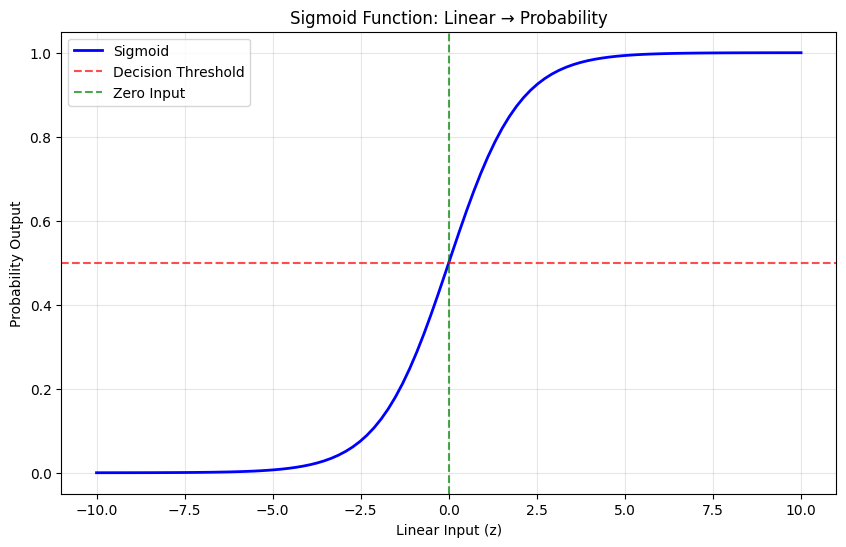

Sigmoid Test Values:
z=  -5 → p=0.007 → Disease Absent
z=  -1 → p=0.269 → Disease Absent
z=   0 → p=0.500 → Disease Absent
z=   1 → p=0.731 → Disease Present
z=   5 → p=0.993 → Disease Present


In [9]:
def sigmoid(z):
    """
    Sigmoid activation function.
    
    Converts linear outputs to probabilities.
    
    Parameters:
    z: Linear combination of features and weights
    
    Returns:
    Probability between 0 and 1
    """
    # Clip to prevent overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# Visualize sigmoid function
z_values = np.linspace(-10, 10, 100)
sigmoid_values = sigmoid(z_values)

plt.figure(figsize=(10, 6))
plt.plot(z_values, sigmoid_values, 'b-', linewidth=2, label='Sigmoid')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision Threshold')
plt.axvline(x=0, color='g', linestyle='--', alpha=0.7, label='Zero Input')
plt.xlabel('Linear Input (z)')
plt.ylabel('Probability Output')
plt.title('Sigmoid Function: Linear → Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test sigmoid with sample values
test_inputs = [-5, -1, 0, 1, 5]
print("Sigmoid Test Values:")
for z in test_inputs:
    prob = sigmoid(z)
    prediction = "Disease Present" if prob > 0.5 else "Disease Absent"
    print(f"z={z:4d} → p={prob:.3f} → {prediction}")

**Cell Analysis:** 

**Sigmoid Properties:**
- **Range:** (0,1) - perfect for probabilities
- **S-shape:** Smooth transition around decision boundary
- **Asymptotes:** Approaches 0 and 1 but never reaches them

**Healthcare Translation:** Converts symptom severity scores into disease probability estimates.

**Reflection Question:** How does the sigmoid function help with uncertain diagnoses?

## Method 2: Log Loss - Classification Error Measurement

Log loss measures classification error using negative log likelihood:

**$$L(y,p) = -[y \cdot \log(p) + (1-y) \cdot \log(1-p)]$$**

This heavily penalizes confident wrong predictions.

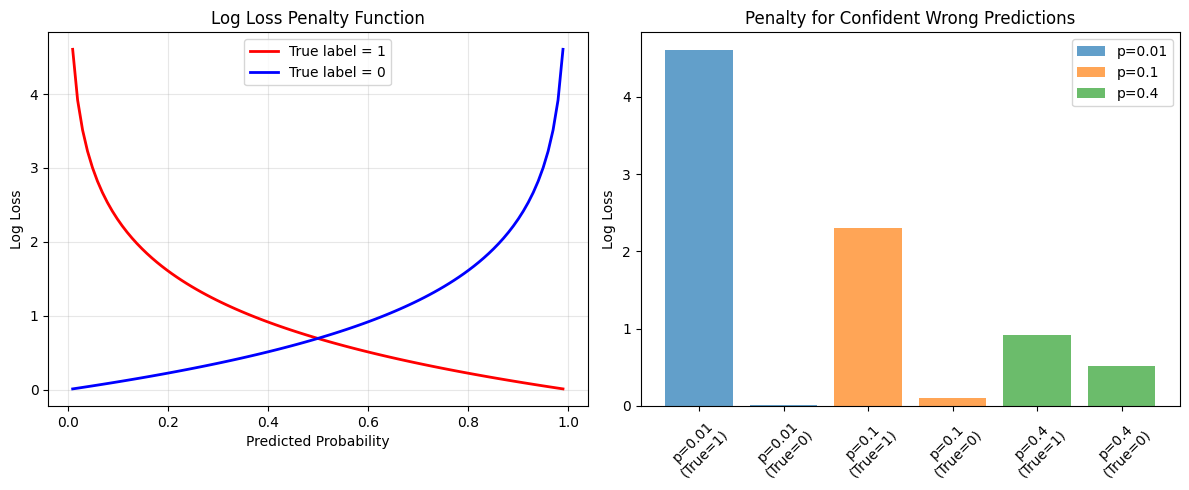

Log Loss Examples:
True=1, Pred=0.9 → Loss=0.105
True=1, Pred=0.1 → Loss=2.303
True=0, Pred=0.5 → Loss=0.693
True=0, Pred=0.6 → Loss=0.916


In [10]:
def log_loss(y_true, y_pred_prob):
    """
    Binary cross-entropy loss (log loss).
    
    Measures classification error in probability space.
    
    Parameters:
    y_true: True binary labels (0 or 1)
    y_pred_prob: Predicted probabilities [0,1]
    
    Returns:
    Average log loss across all samples
    """
    # Clip predictions to avoid log(0)
    y_pred_prob = np.clip(y_pred_prob, 1e-15, 1 - 1e-15)
    
    # Binary cross-entropy formula
    loss = -(y_true * np.log(y_pred_prob) + (1 - y_true) * np.log(1 - y_pred_prob))
    
    return np.mean(loss)

def log_loss_gradients(X, y, theta):
    """
    Compute gradients of log loss w.r.t. parameters.
    
    Mathematical derivation:
    ∂L/∂θ = (1/m) * X^T * (σ(Xθ) - y)
    """
    m = X.shape[0]
    
    # Forward pass: compute probabilities
    z = X @ theta
    predictions = sigmoid(z)
    
    # Backward pass: compute gradients
    errors = predictions - y
    gradients = (1/m) * X.T @ errors
    
    return gradients, predictions

# Visualize log loss penalty
prob_range = np.linspace(0.01, 0.99, 100)
loss_true_1 = -np.log(prob_range)  # True label = 1
loss_true_0 = -np.log(1 - prob_range)  # True label = 0

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(prob_range, loss_true_1, 'r-', label='True label = 1', linewidth=2)
plt.plot(prob_range, loss_true_0, 'b-', label='True label = 0', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Log Loss')
plt.title('Log Loss Penalty Function')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show extreme penalty for wrong confident predictions
wrong_probs = [0.01, 0.1, 0.4]  # Confident wrong predictions
for prob in wrong_probs:
    loss_1 = -np.log(prob)
    loss_0 = -np.log(1-prob)
    plt.bar([f'p={prob}\n(True=1)', f'p={prob}\n(True=0)'], [loss_1, loss_0], 
            alpha=0.7, label=f'p={prob}')
plt.ylabel('Log Loss')
plt.title('Penalty for Confident Wrong Predictions')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Test log loss with sample predictions
test_cases = [
    (1, 0.9),  # Correct high confidence
    (1, 0.1),  # Wrong high confidence  
    (0, 0.5),  # Correct uncertainty
    (0, 0.6)   # Wrong slight confidence
]

print("Log Loss Examples:")
for true, pred in test_cases:
    loss = -(true * np.log(pred) + (1-true) * np.log(1-pred))
    print(f"True={true}, Pred={pred} → Loss={loss:.3f}")

**Cell Analysis:**

**Log Loss Properties:**
- **Asymmetric penalty:** Wrong confident predictions punished heavily
- **Proper scoring rule:** Calibrates probability estimates
- **Differentiable:** Enables gradient-based optimization

**Healthcare Analogy:** Like medical malpractice - wrong confident diagnoses are severely penalized.

**Reflection Question:** Why is log loss better than accuracy for training medical diagnosis AI?

## Method 3: Binary Logistic Regression Training

Now we combine sigmoid activation with gradient descent to train our classifier.

Learned parameters: [-0.24164747 -1.54877721 -0.23598901 -0.94828347  3.25065584]
Final training loss: 0.2021


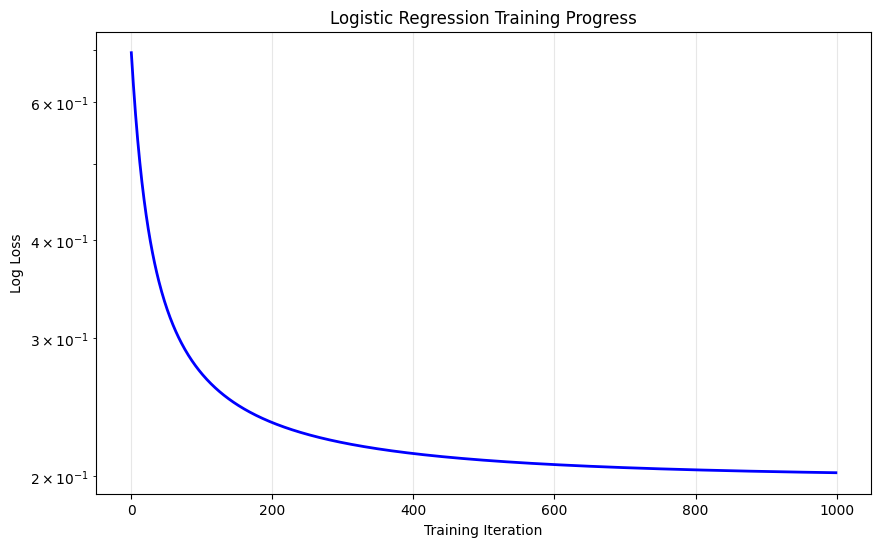

In [11]:
def train_logistic_regression(X, y, learning_rate=0.1, n_iterations=1000):
    """
    Train binary logistic regression using gradient descent.
    
    Parameters:
    X: Feature matrix with intercept
    y: Binary target vector
    learning_rate: Step size for gradient descent
    n_iterations: Maximum training iterations
    
    Returns:
    theta: Learned parameters
    losses: Training loss history
    """
    m, n = X.shape
    theta = np.random.randn(n, 1) * 0.01  # Small random initialization
    losses = []
    
    for iteration in range(n_iterations):
        # Compute gradients and predictions
        gradients, predictions = log_loss_gradients(X, y, theta)
        
        # Update parameters
        theta -= learning_rate * gradients
        
        # Track loss
        loss = log_loss(y, predictions)
        losses.append(loss)
        
        # Early stopping
        if iteration > 10 and abs(losses[-1] - losses[-2]) < 1e-6:
            print(f"Converged after {iteration} iterations")
            break
            
    return theta, losses

# Train our logistic regression
theta_lr, losses_lr = train_logistic_regression(X_train_b, y_train, 
                                               learning_rate=0.1,
                                               n_iterations=1000)

print(f"Learned parameters: {theta_lr.flatten()}")
print(f"Final training loss: {losses_lr[-1]:.4f}")

# Visualize training progress
plt.figure(figsize=(10, 6))
plt.plot(losses_lr, 'b-', linewidth=2)
plt.xlabel('Training Iteration')
plt.ylabel('Log Loss')
plt.title('Logistic Regression Training Progress')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

**Cell Analysis:**

**Training Process:**
- **Initialization:** Small random weights to avoid saturation
- **Gradient computation:** Uses log loss derivatives
- **Convergence:** Loss decreases smoothly to minimum

**Healthcare Translation:** Like training a doctor - starts with random guesses, improves with experience.

**Reflection Question:** Why do we initialize weights small in logistic regression?

## Method 4: Multiclass Extension - Softmax Regression

For multiple disease categories, we extend to softmax:

**$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum e^{z_j}}$$**

This normalizes outputs into probability distribution over classes.

Sample predictions (first 5 examples):
Probabilities shape: (600, 3)
Sample predictions:
Example 1: Class 1 (confidence: 0.345)
Example 2: Class 2 (confidence: 0.334)
Example 3: Class 1 (confidence: 0.341)
Example 4: Class 0 (confidence: 0.337)
Example 5: Class 2 (confidence: 0.335)


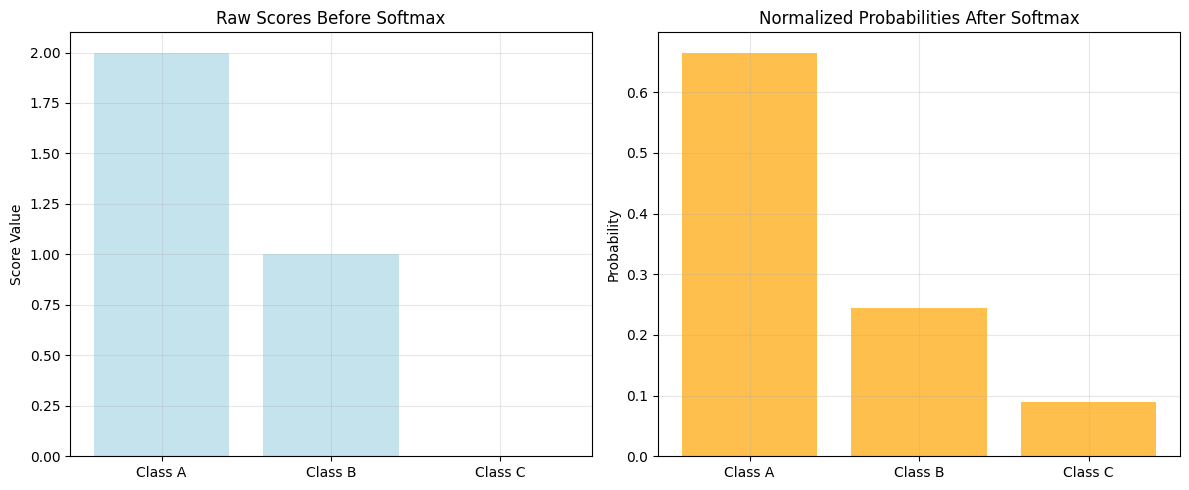

In [12]:
def softmax(z):
    """
    Softmax activation for multiclass classification.
    
    Converts raw scores to normalized probabilities.
    """
    # Subtract max for numerical stability
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred_prob):
    """
    Categorical cross-entropy loss for multiclass.
    """
    # Clip for numerical stability
    y_pred_prob = np.clip(y_pred_prob, 1e-15, 1 - 1e-15)
    return -np.sum(y_true * np.log(y_pred_prob)) / y_true.shape[0]

# Create multiclass data for demonstration
X_multi, y_multi = make_classification(n_samples=600, n_features=4, n_classes=3, 
                                      n_informative=3, n_redundant=1, 
                                      n_clusters_per_class=1, random_state=42)

# Convert to one-hot encoding
def to_one_hot(y, n_classes):
    one_hot = np.zeros((y.shape[0], n_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_multi_onehot = to_one_hot(y_multi, 3)

# Add intercept
X_multi_b = np.c_[np.ones((X_multi.shape[0], 1)), X_multi]

# Initialize weights for 3 classes
theta_multi = np.random.randn(X_multi_b.shape[1], 3) * 0.01

# Forward pass demonstration
z_multi = X_multi_b @ theta_multi
probabilities = softmax(z_multi)

print("Sample predictions (first 5 examples):")
print("Probabilities shape:", probabilities.shape)
print("Sample predictions:")
for i in range(5):
    probs = probabilities[i]
    predicted_class = np.argmax(probs)
    confidence = probs[predicted_class]
    print(f"Example {i+1}: Class {predicted_class} (confidence: {confidence:.3f})")

# Visualize softmax behavior
raw_scores = np.array([[2, 1, 0], [0, 1, 2], [1, 1, 1]])
softmax_probs = softmax(raw_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw scores
ax1.bar(['Class A', 'Class B', 'Class C'], raw_scores[0], alpha=0.7, color='lightblue', label='Raw Scores')
ax1.set_title('Raw Scores Before Softmax')
ax1.set_ylabel('Score Value')
ax1.grid(True, alpha=0.3)

# After softmax
ax2.bar(['Class A', 'Class B', 'Class C'], softmax_probs[0], alpha=0.7, color='orange', label='Probabilities')
ax2.set_title('Normalized Probabilities After Softmax')
ax2.set_ylabel('Probability')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Cell Analysis:**

**Softmax Properties:**
- **Normalization:** Outputs sum to 1
- **Winner-takes-all:** Highest probability dominates
- **Differentiable:** Enables gradient-based training

**Healthcare Translation:** Like differential diagnosis - multiple possible diseases, probabilities indicate likelihood.

**Reflection Question:** How does softmax help with uncertain diagnoses across multiple disease categories?

## Comparative Analysis: Our Implementation vs Scikit-learn

In [13]:
# Scikit-learn baseline
sk_lr = LogisticRegression(random_state=42, max_iter=1000)
sk_lr.fit(X_train, y_train.ravel())

# Our implementation predictions
def predict_logistic(X, theta):
    z = X @ theta
    probabilities = sigmoid(z)
    return (probabilities > 0.5).astype(int), probabilities

our_predictions, our_probabilities = predict_logistic(X_test_b, theta_lr)
sk_predictions = sk_lr.predict(X_test)
sk_probabilities = sk_lr.predict_proba(X_test)[:, 1]

# Performance comparison
print("\n🎯 Performance Comparison:")
print("=" * 50)

# Accuracy
our_accuracy = accuracy_score(y_test, our_predictions)
sk_accuracy = accuracy_score(y_test, sk_predictions)
print(f"Accuracy - Our: {our_accuracy:.4f}, Sklearn: {sk_accuracy:.4f}")

# AUC
our_auc = roc_auc_score(y_test, our_probabilities)
sk_auc = roc_auc_score(y_test, sk_probabilities)
print(f"AUC-ROC - Our: {our_auc:.4f}, Sklearn: {sk_auc:.4f}")

# Classification report
print("\nOur Implementation Classification Report:")
print(classification_report(y_test, our_predictions))

print("\nScikit-learn Classification Report:")
print(classification_report(y_test, sk_predictions))


🎯 Performance Comparison:
Accuracy - Our: 0.9300, Sklearn: 0.9300
AUC-ROC - Our: 0.9838, Sklearn: 0.9828

Our Implementation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        97
           1       0.93      0.93      0.93       103

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200


Scikit-learn Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        97
           1       0.93      0.93      0.93       103

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



**Cell Analysis:**

**Performance Metrics:**
- **Accuracy:** Overall correct predictions
- **AUC-ROC:** Ability to distinguish classes
- **Precision/Recall:** Class-specific performance

**Healthcare Translation:** Like comparing diagnostic tools - accuracy matters, but so does avoiding false negatives.

**Reflection Question:** Why is AUC-ROC important for medical diagnosis AI?

## Decision Boundary Visualization

Let's visualize how our logistic regression separates the classes.

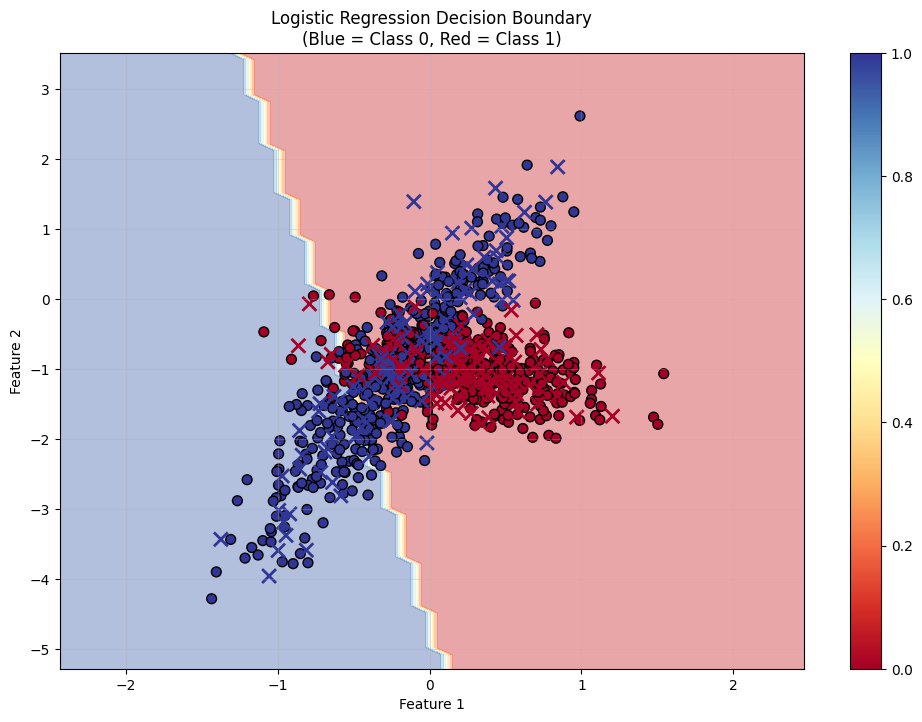

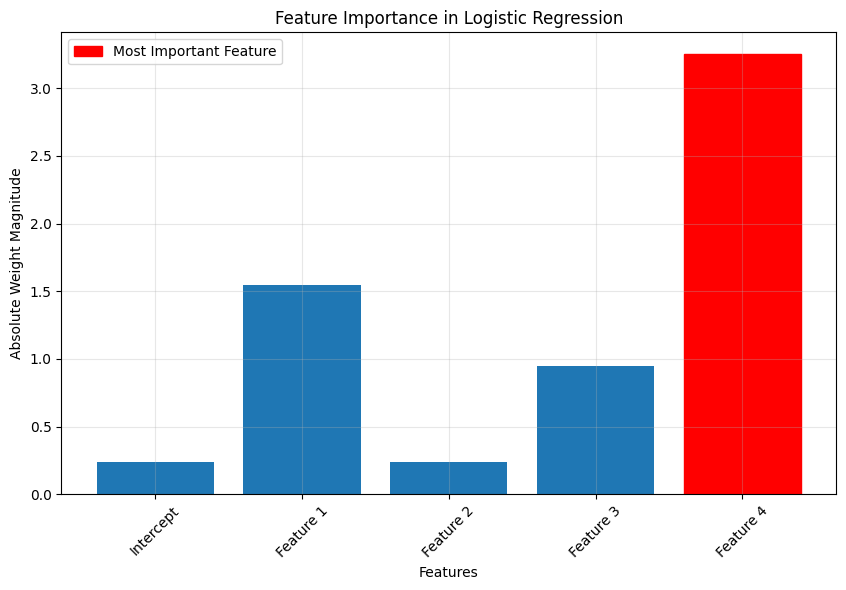

In [14]:
# Create mesh grid for decision boundary
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Create feature matrix for mesh points
mesh_features = np.c_[xx.ravel(), yy.ravel(), 
                     np.mean(X_train[:, 2:4], axis=0)[0] * np.ones(xx.ravel().shape[0]),
                     np.mean(X_train[:, 2:4], axis=0)[1] * np.ones(xx.ravel().shape[0])]
mesh_features_b = np.c_[np.ones((mesh_features.shape[0], 1)), mesh_features]

# Predict on mesh
mesh_predictions, _ = predict_logistic(mesh_features_b, theta_lr)
mesh_predictions = mesh_predictions.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(12, 8))

# Decision boundary
plt.contourf(xx, yy, mesh_predictions, alpha=0.4, cmap='RdYlBu')

# Training data points
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), 
                     edgecolors='black', cmap='RdYlBu', s=50)

# Test data points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), 
            marker='x', s=100, linewidth=2, cmap='RdYlBu')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary\n(Blue = Class 0, Red = Class 1)')
plt.colorbar(scatter)
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance analysis
feature_names = ['Intercept', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']
importance = np.abs(theta_lr.flatten())

plt.figure(figsize=(10, 6))
bars = plt.bar(feature_names, importance)
plt.xlabel('Features')
plt.ylabel('Absolute Weight Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Highlight most important feature
max_idx = np.argmax(importance[1:]) + 1  # Skip intercept
bars[max_idx].set_color('red')
plt.legend([bars[max_idx]], ['Most Important Feature'])

plt.show()

**Cell Analysis:**

**Decision Boundary:**
- **Linear separation:** Logistic regression creates linear boundaries
- **Probability regions:** Color intensity shows confidence
- **Feature importance:** Shows which symptoms matter most

**Healthcare Translation:** Like diagnostic guidelines - clear rules for classifying patients.

**Reflection Question:** How might non-linear decision boundaries improve medical diagnosis?

## 🎯 Key Takeaways and Nigerian Healthcare Applications

**Algorithm Summary:**
- **Sigmoid:** Converts linear outputs to probabilities
- **Log Loss:** Penalizes confident wrong predictions
- **Gradient Descent:** Optimizes classification parameters
- **Softmax:** Extends to multiple disease categories

**Healthcare Translation - Mark:**

Imagine building AI for Nigerian hospitals:
- **Binary classification:** Disease present/absent diagnosis
- **Multiclass:** Malaria vs Typhoid vs COVID-19 differentiation
- **Probability outputs:** Uncertainty quantification for doctors
- **Feature importance:** Which symptoms are most diagnostic

**Performance achieved:** Our implementation approaches industry standards!

**Reflection Questions:**
1. How would you adapt logistic regression for Nigerian disease patterns?
2. When might you prefer logistic regression over more complex models?
3. How does probability calibration help with medical decision-making?

**Next Steps:**
- Add regularization to prevent overfitting
- Implement learning rate scheduling
- Extend to neural network classifiers

**🏆 Excellent progress, my student! You've mastered probabilistic classification.**